In [ ]:
import random as rd

Variant = 20
rd.seed(Variant)

Numbers_of_problems = [rd.sample(range(4),1)[0]+1, rd.sample(range(4),1)[0]+1]
Numbers_of_problems

[2, 3]

# #1

С использованием библиотеки ncurses реализовать случайное блуждание курсора по экрану, курсор не должен уходить за границы экрана, при соударении с границей, он должен менять цвет.

выход на q

```
format ELF64

public _start

extrn initscr
extrn start_color
extrn init_pair
extrn getmaxx
extrn getmaxy
extrn raw
extrn noecho
extrn keypad
extrn stdscr
extrn move
extrn getch
extrn addch
extrn refresh
extrn endwin
extrn timeout
extrn usleep
extrn printw
extrn mvaddch
extrn erase
extrn curs_set

section '.bss' writable
    xmax dq 1
	ymax dq 1
	palette dq 1
    delay dq ?
    buffer db ?
    f db "/dev/random", 0
    rand dq ?

section '.text' executable
_start:

    call initscr
    xor rdi, rdi
	mov rdi, [stdscr]
	call getmaxx
    dec rax
	mov [xmax], rax
	call getmaxy
    dec rax
	mov [ymax], rax

    mov rdi, 0
    call curs_set

    call start_color

    ; COLOR_BLUE
    mov rdi, 1
    mov rsi, 4
    mov rdx, 4
    call init_pair

    ; COLOR_MAGENTA
    mov rdi, 2
    mov rsi, 5
    mov rdx, 5
    call init_pair

    call refresh
	call noecho
    call raw

    xor rax, rax
    mov rax, ' '
    or rax, 0x100
    mov [palette], rax

    mov rax, 2
    mov rdi, f
    mov rsi, 0
    syscall
    mov [rand], rax

    xor r9, r9
    xor r10, r10

    .loop:
        
        mov rdi, r10
        mov rsi, r9
        push r9
        push r10
        mov rdx, [palette]
        call mvaddch
        call refresh

        mov rdi, 1
        call timeout
        call getch
        cmp rax, 'q'
        je .end
        
        mov rax, 0
        mov rdi, [rand]
        mov rsi, buffer
        mov rdx, 1
        syscall

        pop r10
        pop r9
        xor rax, rax
        xor rbx, rbx
        xor rdx, rdx
        mov al, [buffer]
        mov rbx, 3
        div rbx
        sub rdx, 1
        add r9, rdx
        xor rdx, rdx
        div rbx
        sub rdx, 1
        add r10, rdx

        xor rcx, rcx
        cmp r9, 0
        jnl @f
        inc r9
        inc rcx

        @@:
        cmp r9, [xmax]
        jle @f
        dec r9
        inc rcx

        @@:
        cmp r10, 0
        jnl @f
        inc r10
        inc rcx

        @@:
        cmp r10, [ymax]
        jle @f
        dec r10
        inc rcx

        @@:
        cmp rcx, 0
        je .sleep
        mov rax, [palette]
        and rax, 0x100
        cmp rax, 0
        jne .mag
        mov rax, [palette]
        and rax, 0xff
        or rax, 0x100
        jmp @f
        .mag:
        mov rax, [palette]
        and rax, 0xff
        or rax, 0x200
        @@:
        mov [palette], rax

        .sleep:
        push r10
        push r9
        mov rdi, 100000
        call usleep
        call erase
        pop r9
        pop r10
        
        jmp .loop

    .end:
    mov rdi, 1
    call curs_set
    call endwin
    mov rax, 60
    syscall


```



# #2

В программе на ассемблере заполнить массив числами 1, 2, 3,... в количестве N (вводится параметром командной строки), создать два дочерних процесса (clone). Один дочерний процесс должен увеличить на единицу все четные числа, другой - уменьшить на единицу все нечетные. По окончанию работы дочерных процессов родительский процесс должен вывести получившийся массив на экран.



```
format ELF64

include 'func.asm'

public _start

THREAD_FLAGS=2147585792

section '.bss' writable
    array dq ?
    buffer rb 10
    stack1 rq 4096
    stack2 rq 4096
    
section '.text' executable
_start:
    mov rsi, [rsp+16]
    xor rax, rax
    call str_number
    mov r8, rax

    xor rdi,rdi
	mov rax, 12
	syscall
    mov [array], rax
    
    mov rdi, [array]
	add rdi, r8
	mov rax, 12
	syscall

    mov rsi, [array]
    mov rcx, 1
    .fill_loop:
        cmp rcx, r8
        jg .next
        mov byte[rsi], cl
        inc rsi
        inc rcx
        jmp .fill_loop

    .next:    
    mov rax, 56                 ; first child
    mov rdi, THREAD_FLAGS
    mov rsi, 4095
    add rsi, stack1
    syscall

    cmp rax, 0
    je .first

    mov rax, 56                 ; second child
    mov rdi, THREAD_FLAGS
    mov rsi, 4095
    add rsi, stack2
    syscall

    cmp rax, 0
    je .second
    
    mov rax, 61
    mov rdi, -1
    mov rdx, 0
    mov r10, 0
    syscall

    mov rsi, [array]
    xor rcx, rcx
    xor rax, rax
    .print_loop:
        cmp rcx, r8
        je .end
        mov al, byte[rsi+rcx]
        push rsi
        mov rsi, buffer
        call number_str
        call print_str
        call new_line
        pop rsi
        inc rcx
        jmp .print_loop

    .end:
    call exit
    call exit
    
.first:
    mov rsi, [array]
    xor rcx, rcx
    xor rax, rax
    mov rbx, 2
    .even_loop:
        cmp rcx, r8
        je .end

        mov al, byte[rsi+rcx]
        xor rdx, rdx
        div rbx
        cmp rdx, 0
        jne @f
        inc byte[rsi+rcx]

        @@:
        inc rcx
        jmp .even_loop

.second:
    mov rsi, [array]
    xor rcx, rcx
    xor rax, rax
    mov rbx, 2
    .odd_loop:
        cmp rcx, r8
        je .end

        mov al, byte[rsi+rcx]
        xor rdx, rdx
        div rbx
        cmp rdx, 0
        je @f
        dec byte[rsi+rcx]

        @@:
        inc rcx
        jmp .odd_loop

```



Вывод:
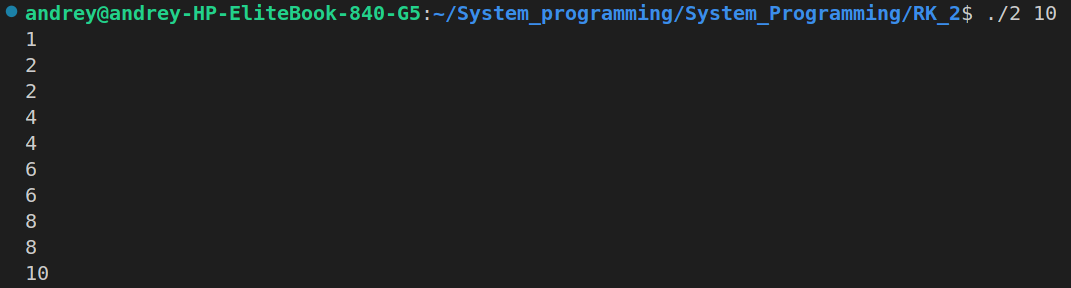
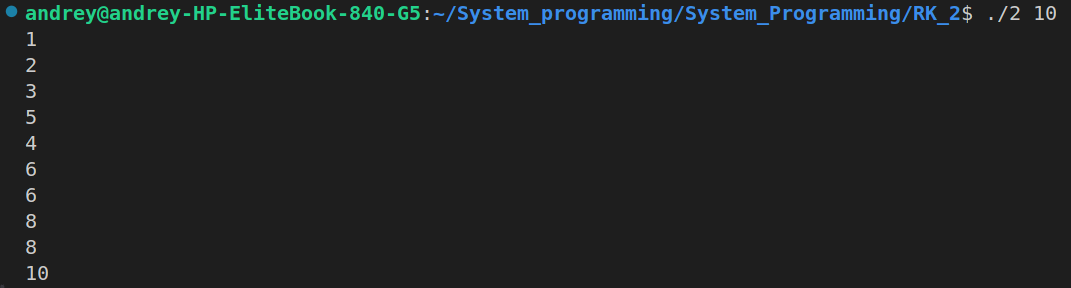
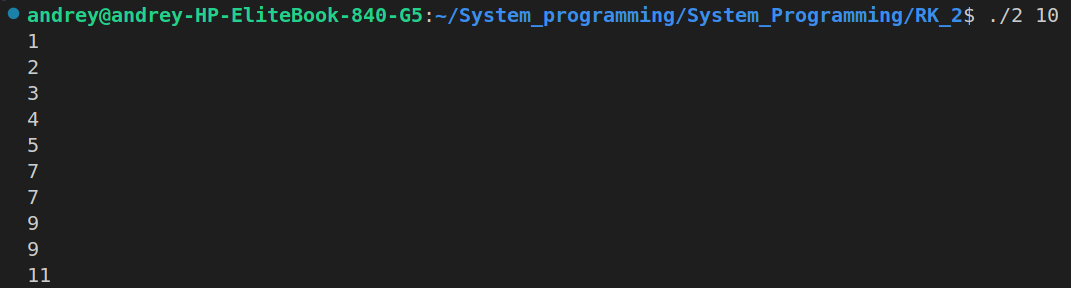